In [177]:
from tokenize import Ignore
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#import models
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_absolute_percentage_error, r2_score

import random
random.seed(2022)

import warnings
warnings.filterwarnings('ignore')

In [178]:
#PREPROCESSING AND TRAIN TEST SPLIT

def preprocessing(data_series, target_column, lags=1, n_forecast= 1): 
	#default values for the lags and n_forecast is set to 1
	#taking log difference of the time series 

	data_series['Log'+target_column] = np.log(data_series[target_column])
	data_series['DiffLog'+target_column] = data_series['Log'+target_column].diff()

	#we will work with the differenced time series data
	series= data_series['DiffLog'+target_column].to_numpy()

	#Convert the time series input data to a supervised dataframe for ML models\
	#second parameter specifies the number of inputs as X (t-1, t-2,.... t-lags)
	supervised_df = time_series_to_supervised(series, lags, n_forecast) 
	#print(supervised_df.head())

	# Setting the input data 
	X= supervised_df.iloc[:, 0:lags].to_numpy()
	#X= X.reshape(-1, lags)

	#building an array for the target variable from the above supervised time series data frame 
	Y= supervised_df.iloc[:, lags:].to_numpy()
	
	#divide the data set into train and test sets
	Xtrain, Ytrain = X[:-Ntest], Y[:-Ntest]
	Xtest, Ytest = X[-Ntest:], Y[-Ntest:]

	print("X train: ", Xtrain.shape, "X test: ", Xtest.shape,"\nY train: ", Ytrain.shape, 'Y test: ', Ytest.shape)
	return Xtrain, Ytrain, Xtest, Ytest

#CONVERT TIME SERIES DATA TO A SUPERVISED DATA FRAME

def time_series_to_supervised(data, n_in=1, n_out=1, dropnan=True): #by default the function takes the previous value at time t-1 and predicts the next prediction at t+1 unless specified. 
	n_vars = 1 
	
	df = pd.DataFrame(data)
	cols, col_names= list(), list()
	
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		col_names += [('x%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
		
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			col_names += [('y%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			col_names += [('y%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns= col_names
	

	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)

	return agg

#MODEL PREDICTIONS
def N_step_forecast(model, data, target_column, Xtrain, Xtest, Ytrain, Ytest, n_forecast, lags):
	model_results={}
	result_df=pd.DataFrame()

	#empty lists for appending model results
	model_names=[]
	train_r2=[]
	test_r2=[]

	#Reverse the differencing operation to get the data back to original format
	data['ShiftLog'+target_column] = data['Log'+target_column].shift(1)
	prev = data['ShiftLog'+target_column]

	# creating indexes for train and test data
	train = data.iloc[:-Ntest]
	test = data.iloc[-Ntest:]
	
	if isinstance(model, list):
		for model_n in model:
			model_n.fit(Xtrain, Ytrain)

			# N-step forecast
			model_name = type(model_n).__name__
			model_names.append(model_name)
			train_r2.append(model_n.score(Xtrain, Ytrain))
			test_r2.append(model_n.score(Xtest, Ytest))

			if n_forecast ==1: #plots have not been plotted for more than 1 forecast in the future
				# Boolean index- create indexing to address train and test sets
				train_idx = data.index <= train.index[-1]
				test_idx = ~train_idx

				train_idx[:lags+1] = False # first lag+1 values are not predictable

				data.loc[train_idx, model_name+'_train'] = prev[train_idx] + model_n.predict(Xtrain).ravel()
				data.loc[test_idx, model_name+'_test'] = prev[test_idx] + model_n.predict(Xtest).ravel()

				# plot forecast
				data[['Log'+target_column,model_name+'_train', model_name+'_test']].plot(figsize=(15, 5))
			else:
				pass
    
	else:
		model.fit(Xtrain, Ytrain)

		# 1-step forecast
		model_name = type(model).__name__
		model_names.append(model_name)
		train_r2.append(model.score(Xtrain, Ytrain))
		test_r2.append(model.score(Xtest, Ytest))

		if n_forecast==1:
			#plotting the original data with the predictied data

			# Boolean index- create indexing to address train and test sets
			train_idx = data.index <= train.index[-1]
			test_idx = ~train_idx

			train_idx[:lags+1] = False # first lag+1 values are not predictable

			data.loc[train_idx, model_name+'_train'] = prev[train_idx] + model.predict(Xtrain).ravel()
			data.loc[test_idx, model_name+'_test'] = prev[test_idx] + model.predict(Xtest).ravel()


			# plot forecast
			data[['Log'+target_column,model_name+'_train', model_name+'_test']].plot(figsize=(15, 5))
		else:
			pass


	model_results= {'Model Name': model_names, 'Train Accuracy': train_r2, 'Test Accuracy': test_r2}

	#create data frame to display results
	results_agg= pd.DataFrame(model_results)
	print(results_agg)
	return results_agg

	

X train:  (121, 10) X test:  (12, 10) 
Y train:  (121, 1) Y test:  (12, 1)
              Model Name  Train Accuracy  Test Accuracy
0       LinearRegression        0.683714       0.649287
1  RandomForestRegressor        0.966668       0.729811
2                    SVR        0.659429       0.505295


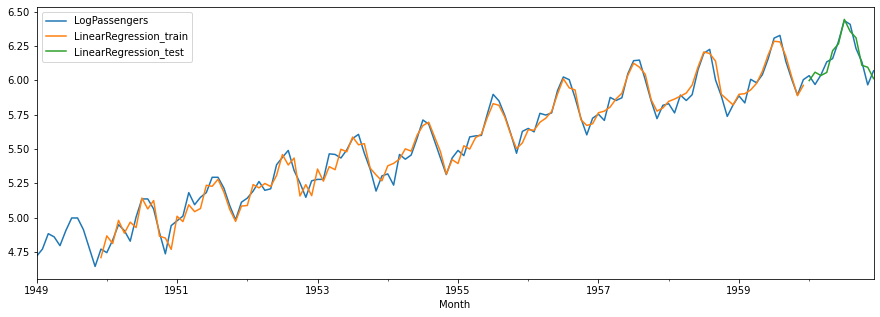

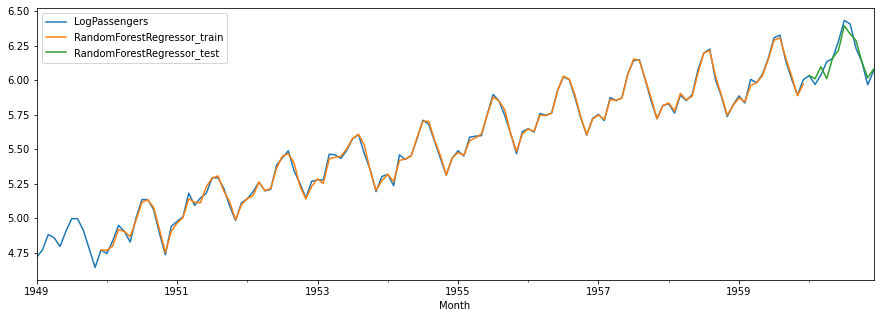

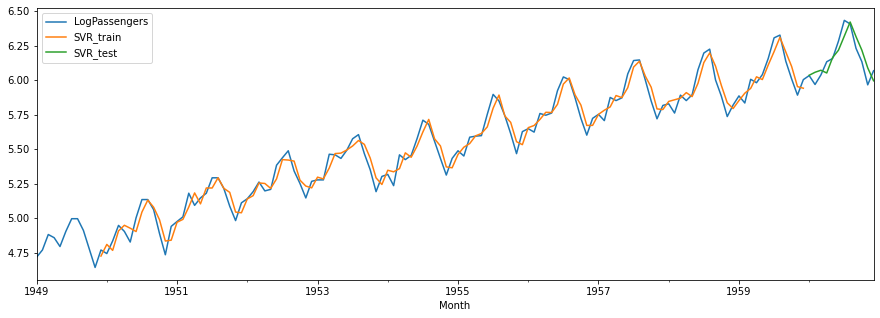

In [179]:
#define data set parameters- Univariate forecasting (SINGLE PREDICTOR COLUMN)
dataset='airline_passengers.csv'
index_column='Month'
target_column='Passengers'

# set parameters for forecasting
lags= 10
n_forecast= 1
Ntest= 12

# read the data set and apply train test split
df = pd.read_csv(dataset, index_col=index_column, parse_dates=True)

#split dataset into train test sets
Xtrain, Ytrain, Xtest, Ytest = preprocessing(df, target_column, lags, n_forecast)

#forecast
forecast_results= N_step_forecast([LinearRegression(), RandomForestRegressor(), SVR()], df, 
target_column, Xtrain, Xtest, Ytrain, Ytest, n_forecast, lags)

# forecast_results= N_step_forecast(LinearRegression(), df, 
# target_column, Xtrain, Xtest, Ytrain, Ytest, n_forecast, lags)



In [180]:
n_forecast= 30

#split dataset into train test sets
Xtrain, Ytrain, Xtest, Ytest = preprocessing(df, target_column, lags, n_forecast)

#forecast
forecast_results= N_step_forecast([LinearRegression(), RandomForestRegressor()], df, 
target_column, Xtrain, Xtest, Ytrain, Ytest, n_forecast, lags)

X train:  (92, 10) X test:  (12, 10) 
Y train:  (92, 30) Y test:  (12, 30)
              Model Name  Train Accuracy  Test Accuracy
0       LinearRegression        0.792015       0.826963
1  RandomForestRegressor        0.976110       0.876794


Note: SVR, Logistic regression etc. work only for a single forecast into the future. 